In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

sns.set_style()

pd.set_option('display.max_columns', None)

%matplotlib inline

# Import preprocessed data 

In [2]:
train = pd.read_csv("data/train_cleaned.csv")

# remove unnamed and index columns
train = train.iloc[:, 2:]

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1453 entries, 0 to 1452
Data columns (total 58 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1453 non-null   int64  
 1   mssubclass     1453 non-null   int64  
 2   mszoning       1453 non-null   object 
 3   lotfrontage    1453 non-null   float64
 4   lotarea        1453 non-null   int64  
 5   lotshape       1453 non-null   int64  
 6   landcontour    1453 non-null   object 
 7   lotconfig      1453 non-null   object 
 8   landslope      1453 non-null   object 
 9   neighborhood   1453 non-null   object 
 10  condition1     1453 non-null   object 
 11  bldgtype       1453 non-null   object 
 12  housestyle     1453 non-null   object 
 13  overallqual    1453 non-null   int64  
 14  overallcond    1453 non-null   int64  
 15  yearbuilt      1453 non-null   int64  
 16  yearremodadd   1453 non-null   int64  
 17  roofstyle      1453 non-null   object 
 18  masvnrty

In [4]:
# convert mssubclass to string again since it got converted back to int on import
train['mssubclass'] = train['mssubclass'].astype(str)

# One-hot encoding 

In [5]:
train_dummies = pd.get_dummies(train, drop_first = True)

In [6]:
train_dummies.shape

(1453, 158)

# Train-test-split 

In [7]:
x = train_dummies.loc[:, train_dummies.columns != 'saleprice']
y = train_dummies[['saleprice']]

print(x.shape)
print(y.shape)

# train test split
np.random.seed(100)
xtest, xtrain, ytest, ytrain = train_test_split(x, y, test_size = 0.7, random_state = 7)
    # (wrong order but too late to change. but training data is 70% according to shape)
    
print(xtrain.shape)
print(ytrain.shape)

(1453, 157)
(1453, 1)
(1018, 157)
(1018, 1)


# Scale data 

In [8]:
# scale data - standardscaler
scaler = StandardScaler()

xtrain_scaled = scaler.fit_transform(xtrain)
xtest_scaled = scaler.transform(xtest)

# Hyperparameter tuning 

lasso alpha $\alpha$

In [9]:
l_alpha = np.arange(0.001,0.15,0.0025)

# fits multiple alphas
lassocv = LassoCV(alphas = l_alpha, cv = 5)
lassocv = lassocv.fit(xtrain_scaled, ytrain)

print('optimal lasso alpha: ', lassocv.alpha_)
print('best lasso R2: ', lassocv.score(xtrain_scaled, ytrain))

optimal lasso alpha:  0.1485
best lasso R2:  0.9221506924964251


Standard LinearRegression 

In [10]:
from sklearn.linear_model import LinearRegression

# fit linear regression model
linreg = LinearRegression()
linreg.fit(xtrain_scaled, ytrain)

print('linear regression R2: ', linreg.score(xtrain_scaled, ytrain))

linear regression R2:  0.9219931333468336


Cross validation 

# Model evaluation

In [11]:
lasso = Lasso(alpha = lassocv.alpha_)

# --------------------------------------- DEFINE ERROR METRICS ---------------------------------------
def rmse(ytest, ypred):
    return np.sqrt(mean_squared_error(ytest, ypred))

# fit model to train data
lasso_mod = lasso.fit(xtrain_scaled, ytrain)
# predict on test data
ypred = lasso_mod.predict(xtest_scaled)
# evaluate model performance
print('lasso test R2: ', lasso_mod.score(xtest_scaled, ytest))
print('lasso test RMSE: ', rmse(ytest, ypred))


lasso test R2:  0.8977359812072836
lasso test RMSE:  25265.948498909154


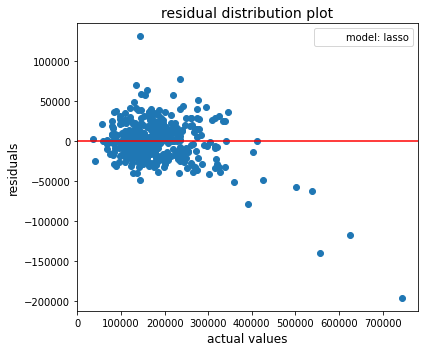

In [12]:
# plot residuals
resid = ypred - ytest.saleprice

plt.rcParams['figure.figsize'] = (6.0, 5.0)
plt.scatter(ytest.saleprice, resid)
plt.axhline(0, linestyle='-', color='r')
plt.title('residual distribution plot',fontsize=14)
plt.xlabel('actual values',fontsize=12)
plt.ylabel('residuals',fontsize=12)
plt.plot([], [], ' ', label="model: lasso")
plt.legend()
plt.tight_layout()

In [13]:
# plot ypred vs ytrue
# fig, ax = plt.subplots(figsize=(6.0, 6.0))
# ax.scatter(ytest.saleprice, ypred)
# ax.set_title('predicted values distribution plot',fontsize=14)
# ax.set_xlabel('actual values',fontsize=12)
# ax.set_ylabel('predicted values',fontsize=12)
# ax.set_xlim(20,45)
# ax.set_ylim(20,45)
# ax.plot(ax.get_xlim(), ax.get_ylim(), ls="-", c="r")
# plt.plot([], [], ' ', label="model: lasso")
# plt.legend()
# plt.tight_layout()